# Data Augmentation With Gaussian Mixture Models

### Summary

Imbalanced data can affect the accuracy of machine learning models.  Here, we will augment our data using a Gaussian Mixture Model as a means of improving model accuracy.

In this notebook, we will intentionally create an imbalanced dataset.  Then, we will augment the imbalanced dataset and observe the impact on model performance.

### Data Preparation

Import common libraries

In [4]:
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets, svm, metrics

from sklearn.mixture import GaussianMixture

Our exercise dataset will be the digits dataset provided by the Sci-Kit Learn library.

In [5]:
digits = load_digits()

# Create structures for data and labels.
all_data = digits.data
all_labels = digits.target

We will divide our data into training and test sets.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.5, random_state=10)

### Creating Imbalance

To create imbalance in our training dataset, we will remove most of the images for the digit 8.

We start with 90 images in our training set and will reduce that to 10 images.

In [10]:
# Assigning our target digit to a variable avoids hardcoding
target_digit = 8

# How many do we have to start?
len([i for i in y_train if i == target_digit])

90

In [11]:
# Limit represents the number of images we want to keep
limit = 10

# Data structures to store our imbalanced dataset
reduced_y_train = []
reduced_X_train = []

# Loop through the training set, 
for index in range(len(y_train)):
    
    if y_train[index] == target_digit:
        
        #  Keep target digits up to the limit
        if limit > 0:
            limit = limit - 1
            reduced_y_train.append(y_train[index])
            reduced_X_train.append(X_train[index])
        
        # Discard target digits after the limit
        else:
            doNothing = True
    
    # Keep anything that isn't a target digit
    else:
        reduced_y_train.append(y_train[index])
        reduced_X_train.append(X_train[index])

In [12]:
# Number of target digits after the imbalancing
len([i for i in reduced_y_train if i == target_digit])

10

### Model Training on the Imbalanced Dataset

With an imbalanced dataset prepared, we will now train a Support Vector Machine (SVM) model to classify the digits.

In [15]:
# Declare an SVM
classifier = svm.SVC(gamma=0.001)

# Fit the model to the imbalanced dataset
classifier.fit(reduced_X_train, reduced_y_train)

# Test our model
predicted = classifier.predict(X_test)

# Accuracy report
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        81
           1       0.84      1.00      0.92        92
           2       0.99      1.00      0.99        91
           3       0.90      0.99      0.94        90
           4       0.98      1.00      0.99        84
           5       0.94      0.98      0.96        97
           6       0.99      0.98      0.98        94
           7       0.98      1.00      0.99        98
           8       1.00      0.35      0.51        84
           9       0.79      0.98      0.87        88

   micro avg       0.93      0.93      0.93       899
   macro avg       0.94      0.93      0.92       899
weighted avg       0.94      0.93      0.92       899



As expected our 

In [32]:
eights = [reduced_X_train[index] for index, i in enumerate(reduced_y_train) if i == 8]
eights = np.array(eights)
eights.shape

(10, 64)

In [33]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(eights)

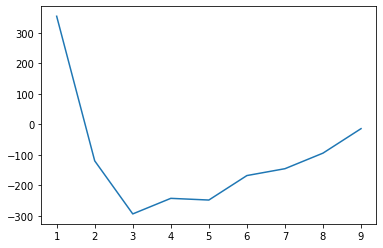

In [36]:

n_components = np.arange(1, 10, 1)
models = [GaussianMixture(n, covariance_type='full', random_state=0) for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

In [37]:
gmm = GaussianMixture(3, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


In [38]:
data_new = gmm.sample(100)
np.array(data_new[0][0]).shape

(9,)

In [40]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)

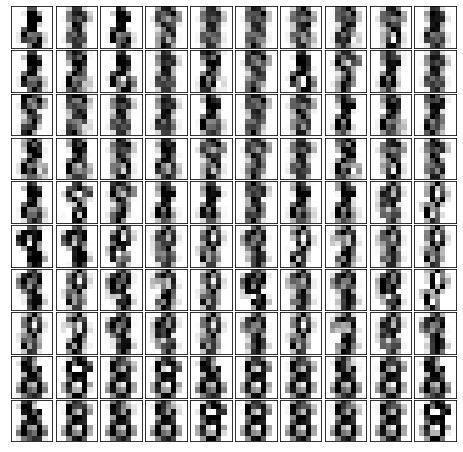

In [41]:
digits_new = pca.inverse_transform(data_new[0])
plot_digits(digits_new)

In [67]:
augmented_X_train = np.concatenate((reduced_X_train, digits_new))
augmented_X_train.shape

(918, 64)

In [69]:
augmented_y_train = np.concatenate((reduced_y_train, [8]*digits_new.shape[0]))
augmented_y_train.shape

(918,)

In [70]:
# Create a classifier: a support vector classifier
augmented_classifier = svm.SVC(gamma=0.001)

# We learn the digits on the first half of the digits
augmented_classifier.fit(augmented_X_train, augmented_y_train)

# Now predict the value of the digit on the second half:
predicted = augmented_classifier.predict(X_test)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))

Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        81
           1       0.93      1.00      0.96        92
           2       0.99      1.00      0.99        91
           3       0.93      0.99      0.96        90
           4       0.99      1.00      0.99        84
           5       0.94      0.98      0.96        97
           6       0.99      0.98      0.98        94
           7       0.99      1.00      0.99        98
           8       1.00      0.70      0.83        84
           9       0.91      0.98      0.95        88

    accuracy                           0.96       899
   macro avg       0.97      0.96      0.96       899
weighted avg       0.97     